In [14]:
# load the package
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os 

os.getcwd()

'/mnt/bioSSD/Demo_Esophagus'

In [15]:
# load the data
adata = sc.read_10x_mtx("./original/ESC1",make_unique=True)
print(adata)

AnnData object with n_obs × n_vars = 4505 × 27984
    var: 'gene_ids', 'feature_types'


In [16]:
# add metadata for this sample
adata.obs["sample"]="ESC1"
adata.obs["response"]="sensitive"
print(adata)

AnnData object with n_obs × n_vars = 4505 × 27984
    obs: 'sample', 'response'
    var: 'gene_ids', 'feature_types'


In [17]:
# Quality Control: Remove cells of low quality
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False)
print(adata)

AnnData object with n_obs × n_vars = 4505 × 27984
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


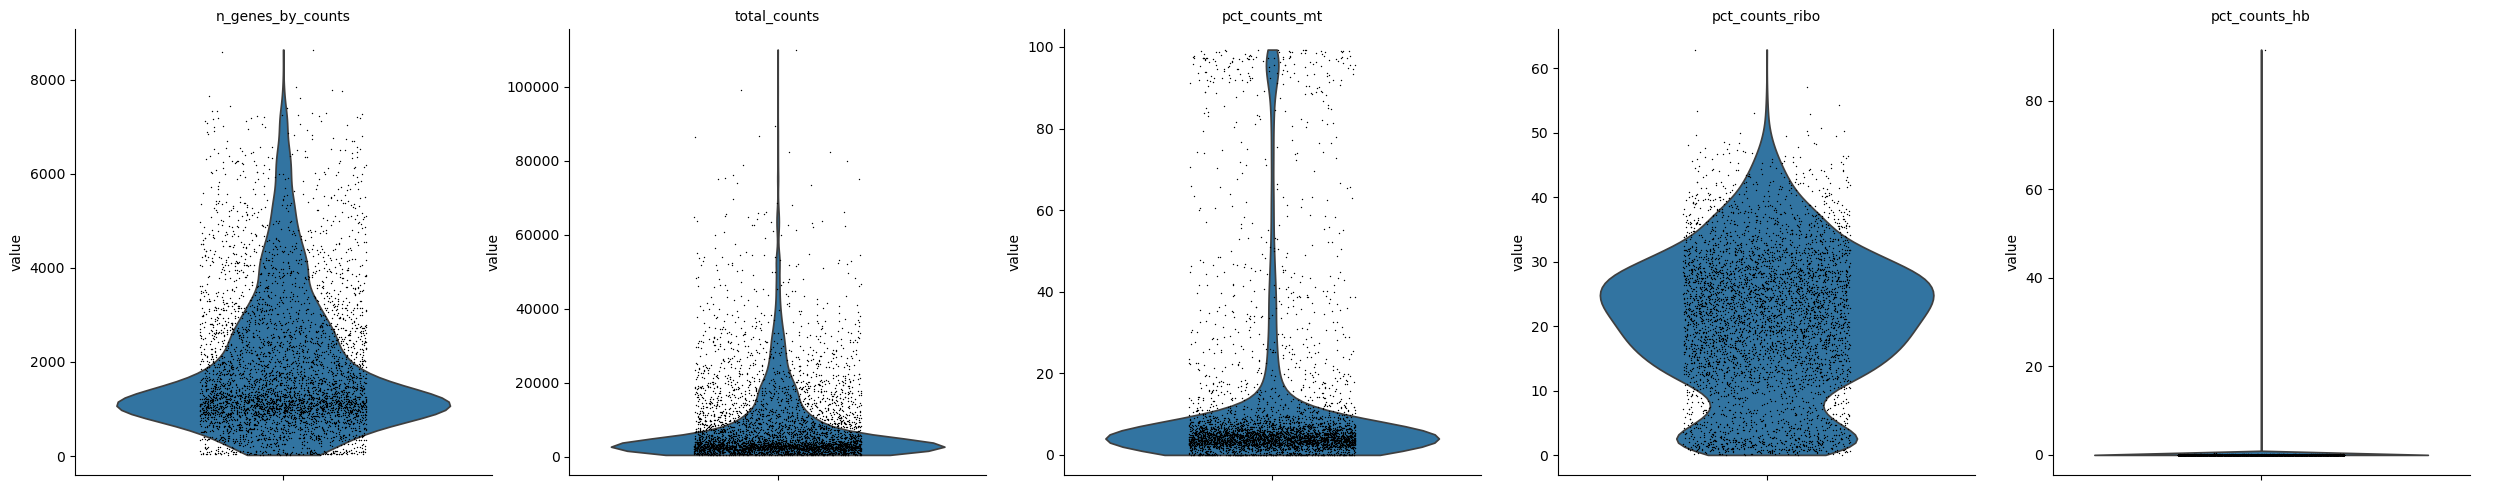

In [18]:
# draw violin plot for determining proper QC standard
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt",'pct_counts_ribo','pct_counts_hb'],
    jitter=0.2,
    multi_panel=True,
)

In [19]:
# since this is a sample collected from tumor, we elevate the standard for mitochondrial gene percentage to 30
adata = adata[
    (adata.obs['n_genes_by_counts'] > 200) &
    (adata.obs['pct_counts_mt'] < 30) &
    (adata.obs['pct_counts_hb'] < 1),
    :
]
print(adata)

View of AnnData object with n_obs × n_vars = 4096 × 27984
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [20]:
# Quality Control: Doublet Removal
sc.pp.scrublet(adata, batch_key="sample")
print(adata.obs["predicted_doublet"].value_counts())

predicted_doublet
False    4094
True        2
Name: count, dtype: int64


In [21]:
adata=adata[(adata.obs["predicted_doublet"] == False)]
print(adata)

View of AnnData object with n_obs × n_vars = 4094 × 27984
    obs: 'sample', 'response', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


In [22]:
adata.write_h5ad("ESC1_post_QC.h5ad",compression="gzip")